# Data Science: Bridging Principles and Practice
## Part 11: The A/B Test (Rocket Fuel case study)

<img src="images/ab_test.PNG" style="width: 900px; height: 250px;" />


### Table of Contents


11 - [Example: Rocket Fuel A/B Test](#section11)<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a - [Permutations](#section11a)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b - [Simulation](#section11b)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c - [P-Values, T-Tests, and Standard Error](#section11c)

In [1]:
# load some necessary software: THIS CELL MUST BE RUN
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind
import seaborn as sns
from numpy.random import permutation
from gofer.ok import check

# set the random seed for reproducibility
np.random.seed(28)

In [2]:
# load the Rocket Fuel data
ads = pd.read_csv('data/rocketfuel_data_renamed.csv', index_col=0)

# display the first ten rows
ads.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


## 11. The Rocket Fuel A/B Test <a id="section11"></a>

Rocket Fuel's initial goal was to say whether or not the advertising campaign they ran for TaskBella was effective. In Notebook 10, we started to answer this question by calculating the *difference in average rates of conversion* between the control (PSA) group and the test (ad) group. However, we don't yet know if that difference is *statistically significant*. 

This notebook will show how to calculate measures of statistical significance in Python, including how to:

- use **randomization** for hypothesis testing
- run a **permutation test** to see if the observed results of an A/B test are significant
- calculate the **p-value** and **standard error**


The code to calculate the difference is replicated below, in compressed form. Run next two cells to output the two rates and the difference between them.

In [3]:
# a DataFrame with the conversion rates for the ad and psa groups
avgs_by_group = ads.groupby("test group").mean()

# an array with the two conversion rates
observed_rates = avgs_by_group["converted"]

# the difference between the average ad and psa rates
observed_diff = observed_rates[0] - observed_rates[1]
observed_diff

0.007692453192201517

We can see that there is a difference, but that difference is very small. What we now what to know is whether that difference is *significant*. Can the difference between the two rates be explained by chance variation? Or, is the difference too large to be likely under chance variation, providing evidence that the ad campaign was effective in increasing bag purchases?

Our hyptheses are as follows:

- **Null hypothesis:** users who saw ads were just as likely to purchase a handbag as users who saw PSAs. Any difference in the conversion rates seen in the sample data is due to random chance.

- **Alternative hypothesis:** users who saw ads were more likely to buy handbags than users who saw PSAs.

### 11a. Permutation <a id="section11a"></a>

If we assume the null hypothesis, then any user had the same chance of converting as any other, regardless of whether or not they saw the ad. This means that if we took all the values from the "converted" column and randomly reassigned them to all the users in the study (both control and experimental group members), we should see a similar difference in conversion rates between the two groups.

The `permutation` function from the Numpy library can help us out with the random reassignment. Let's look at an  array of the numbers 1 through 10.

In [4]:
# a DataFrame of numbers
numbers = np.arange(1, 11)
numbers

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

`permutation` takes the values in an array, randomly shuffles them, and returns a new array of the same length with the values in a different order. Run the next cell a few times to see a few different permutations.

In [5]:
# get a random permutation of the numbers array
permutation(numbers)

array([10,  3,  9,  8,  4,  1,  5,  7,  6,  2])

Note that this is equivalent to **sampling without replacement**: picking the numbers 1-10 out of a metaphorical hat one-by-one, where each number is as likely as any other number to be chosen, but once a number is chosen ("pulled out of the hat") it will not be chosen again.
    
Now we can permute the values in our "converted" column.

In [6]:
# select the "converted" column.
converted = ads["converted"]

# permute the "converted" column
converted_permutation = permutation(converted)
converted_permutation

array([False, False, False, ..., False, False, False])

We then want to attach this column of shuffled values to our original `ads` DataFrame.

In [7]:
# add a new column with the permutation
ads["converted permutation"] = converted_permutation
ads.head()

,user id,test group,converted,total ads,most ads day,most ads hour,converted permutation
0,1069124,ad,False,130,Monday,20,False
1,1119715,ad,False,93,Tuesday,22,False
2,1144181,ad,False,21,Tuesday,18,False
3,1435133,ad,False,355,Tuesday,10,False
4,1015700,ad,False,276,Friday,14,False


Then, we group by "test group" again to see the conversion rates by group for the permutation.

In [8]:
# group by test group
with_perm = ads.groupby("test group").mean()

perm_rates = with_perm["converted permutation"]
perm_rates

test group
ad     0.025231
psa    0.025421
Name: converted permutation, dtype: float64

And finally, we calculate the difference between the "ad" and "psa" group conversion rates for the permutation.

In [9]:
# the difference between the permutation ad and psa group rates
perm_rate_diff = perm_rates[0] - perm_rates[1]

# print the original rate difference and the permutation rate difference
print("Observed conversion rate difference: ", observed_diff, 
     "\nPermutation conversion rate difference: ", perm_rate_diff)

Observed conversion rate difference:  0.007692453192201517 
Permutation conversion rate difference:  -0.00018956744757011798


<div class="alert alert-warning">
    <b>QUESTION:</b> How does the difference in conversion rates for the permuted data compare to the conversion rate difference we saw in the original observed sample? What might that imply regarding our hypotheses?
    </div>

**ANSWER:**

### 11b. Simulation <a id="section11b"></a>

Here we run into a problem similar to our original issue: how do we know that the difference seen in this new permutation is *also* not due to random chance?

One way is to repeat the process from section 11a- randomly permute the conversion data, attach it to the test group labels in their original order, and calulate the test statistic- many, many times. This will give us the **empirical distribution** of values for the **test statistic** (the difference between the two conversion rates). 

To simplify things, we've made a function that does all of code in part 11a. `calc_perm_rate_diff` randomly shuffles the values in "converted", groups them by test group, and returns the difference between the conversion rates for the two groups. Try running the cell a few different times to see what values it calculates.

In [10]:
# calculate the test statistic for a random permutation
def calc_perm_rate_diff():
    """Randomly permute the conversion data and return 
    the difference in conversion rates between the control and 
    experimental groups."""
    perm = np.random.permutation(ads["converted"])
    test_pd = ads["test group"]
    control = perm[test_pd == "psa"]
    exper = perm[test_pd == "ad"]
    return np.mean(exper) - np.mean(control)

calc_perm_rate_diff()

-0.0005438155662115425

#### `For` Loops

We want to calculate the test statistic many times, but ideally we want to do so without copying and pasting calls to `calc_perm_rate_diff` thousands of times.

Thankfully Python has a statement called a **`for` loop** that allows us to repeat an action or set of actions over and over again. Here's an example:

In [11]:
# a for loop
for i in range(5):
    print("Hi there!")

Hi there!
Hi there!
Hi there!
Hi there!
Hi there!


We can break down a `for` loop statement (i.e. the second line in the above cell) into four parts:

- The word "for"
- A name we want to give each item in a sequence
- The word "in"
- A sequence (e.g. "range(5)" to go through numbers 0 up to but not including 5)

The `for` loop statement tells the computer to do all of the indented code below the statement (also called the code "inside" the loop), for each item in the sequence. So, if we want to calculate the test statistic for 1000 permutations of the "converted" data, we can put our calculcation function inside a `for` loop.

We want to be careful: unless we save the calculations somewhere outside the loop, the computer will just overwrite them each time it goes through the loop. The next cell creates an empty array called `diff_array` to store the differences we calculate and adds an extra command inside the `for` loop to add each difference to the list after it's calculated.

Run the next cell to calculate the test statistic for 1,000 permutations of the data. 

<div class="alert alert-info">Note: this cell may take up to a minute to finish running (remember- the computer is working with almost 600,000 rows, and it's doing it 1,000 times).</div>

In [12]:
n = 1000
diff_array = np.empty(n)

for i in range(n):
    # calculate the rate difference
    diff = calc_perm_rate_diff()
    
    # add the difference to the array
    diff_array[i] = diff
    
    # code to periodically print out a status update
    if i % 100 == 0:
        print("{}% done".format(i/10))
    elif i == 999:
        print("done!")


0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
done!


Now, let's put all the test statistics we calculated in a DataFrame.

In [13]:
# DataFrame of calculated test statistics
differences = pd.DataFrame({"rate difference": diff_array})
differences.head()

,rate difference
0,-0.000455
1,0.000298
2,0.000342
3,0.001405
4,-0.000942


And finally, we'll use `.hist` to visualize the empirical distribution of the test statistic in a histogram. We've increased the optional `bins` argument from the default value to see a bit more detail.

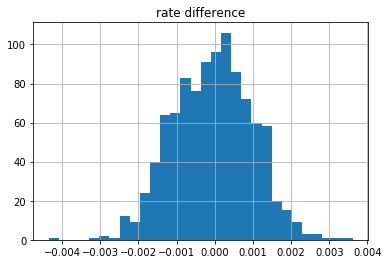

In [14]:
# the empirical distribution of the test statistic
differences.hist("rate difference", bins=30);

We see that the distribution is roughly normal and centered around zero, which makes sense since our null hypothesis assumes that the control and experimental group conversion rates are the same, and the difference between two equal rates is zero.

Now, let's see where the rate difference we observed in the original sample falls compared to these rates. The following cell plots the histogram again and adds a vertical line at the value of the test statistic in the original sample.

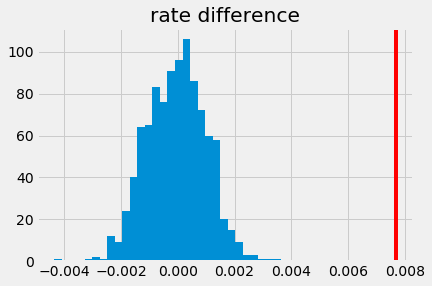

In [15]:
# plot the empirical histogram
plt.style.use("fivethirtyeight")

differences.hist("rate difference", bins=30);

# plot the original sample statistic
plt.axvline(x=observed_diff, color="r")

### 11c. P-Values, T-Tests, and Standard Error <a id="section11c"></a>

Our original observed difference looks like it falls way outside all the the values in the empirical distribution. We can also note that our empirical distribution looks roughly normal- this makes sense by the <a href="https://en.wikipedia.org/wiki/Central_limit_theorem">Central Limit Theorem</a> because our test statistic is an average.

We can get a measure of exactly how far outside it is by calculating the <b>p-value</b>. Remember, the p-value in this case is the chance that, under the null hypothesis, the average difference in conversion rates is the *as large or larger* than the difference we saw in our original sample.

<div class="alert alert-info">
    <b>Two-Tailed vs One-Tailed P Values</b>
    We are calculating the <b>one-tailed p value</b>: the chance that a rate difference average under the null is as large or larger than the observed difference. Many analyses instead calculate the <a href="https://en.wikipedia.org/wiki/One-_and_two-tailed_tests"><b>two-tailed p value</b></a> the chance that a rate difference average under the null is <i>as extreme or more extreme</i> than the observed difference, on either side of the empirical distribution (that is, as far from the mean both to the right and left). The one-tailed value is helpful here because we're interested in whether the average experimental rate was <i>significantly bigger</i> than the average control rate. If instead we wanted to know whether the two groups were <i>significantly different</i> (that is, the experimental rate was significantly bigger or smaller), we would use the two-sided p test.


</div> 

<br/>

<div class="alert alert-warning">
    <b>EXERCISE:</b> Calculate the empirical p-value.  
    <ol>
        <li>Create a DataFrame <code>more_than_original</code> that contains all the rows of <code>differences</code> where <code>rate_difference</code> is greater than or equal to <code>observed_diff</code>. This code has been given.</li>
        <li>Get the count of items in the <code>more_than_original</code> DataFrame and the count of items in the <code>differences</code> DataFrame. Hint: the DataFrame attribute <code>shape</code> is helpful- remember, it's called using dot notation and doesn't have parentheses after since it's an attribute, not a function.</li>
        <li>Divide <code>more_than_count</code> by <code>total_diffs_count</code> to get the empirical p-value.</li>
    </ol>
    </div>

In [16]:
#  A DataFrame of values in the empirical distribution that are at least as large as the observed rate difference
more_than_original = differences[differences["rate difference"] >=observed_diff]

# the number of rows in more_than_original
more_than_count = more_than_original.shape[0]
# the number of rows in differences
total_diffs_count = differences.shape[0]

# the empirical p value
empirical_p = more_than_count/total_diffs_count
empirical_p

0.0

In [17]:
('more_than_count' in vars()) and (more_than_count != ...)

True

In [18]:
# run this cell to check your answer for some commom errors
check("tests/11/empirical-p.ok")

We can check our work with a pre-made function, as well. Because it is a common operation, the **Scipy** Python library for math, science, and engineering has a function that calculates the T-test for two independent samples. `ttest_ind` takes two arguments- the two arrays containing the samples from the two different groups- and returns the calculated T statistic and the two-sided p value.

The **T statistic** is similar to the **z score**, but used when the population parameters (like the standard deviation) are unknown.

Since our test statistic is normally distributed, the one-tailed p value should be half of the two-tailed.

Note that very small values will be returned in *scientific notation*, specifically [*e-notation*](https://en.wikipedia.org/wiki/Scientific_notation#E-notation).

In [19]:
# divide our DataFrame into experiment and control groups
exper_group = ads[ads["test group"] == "ad"]
control_group = ads[ads["test group"] == "psa"]

# get the conversion data as arrays
exper_conversion = exper_group["converted"]
control_conversion = control_group["converted"]


# calculate the T-statistic and P-value for the 
ttest_ind(exper_group["converted"], control_group["converted"])

Ttest_indResult(statistic=7.37040597428566, pvalue=1.7033052627831264e-13)

<div class="alert alert-warning">
    <p><b>QUESTION:</b> A statistically significant p value is conventionally defined as less than or equal to 0.05, and a highly significant p value is conventionally defined as less than or equal to 0.01. </p>
    <p>
    <ul>
        <li>Is the p-value we see significant?</li>
        <li>Given the p-value <i>alone</i>, should we recommend that Taskbella should continue the ad campaign? If not, what other information (perhaps from the first notebook) would we need, and what should our recommendation be</li>
        </ul>
        </p>
    </div>

**ANSWER:**

#### References

- Rocket Fuel data and discussion questions adapted from materials by Zsolt Katona and Brian Bell, BerkeleyHaas Case Series
- "For loop" section adapted from materials by Kelly Chen at [UC Berkeley Data Modules](https://github.com/ds-modules/core-resources)

Author: Keeley Takimoto